## Estimation of Bayes' Error for Gaussian Parity

In [1]:
# Created by: Aishwarya Seth
# Date: 2nd October, 2021
# Contact At: aishwarya.seth6@gmail.com

In [2]:
import numpy as np 
from sklearn.datasets import make_blobs
from numpy.random import uniform, normal
from sklearn.ensemble import RandomForestClassifier as rf
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

### What is Bayes' Error? 
#### In statistical classification, Bayes error rate is the lowest possible error rate for any classifier of a random outcome, i.e. it is the error inherent in the problem definition

### Problem Definition: Gaussian Parity

#### Blob Creation
Using the user-defined cluster centers as the means, and the user-defined cluster standard deviation, a set of 4 blobs is created. These blobs are multivariable normal distributions. 

After all 4 blobs are created, the classes are assigned. The class is assigned so that graph quadrants 1 & 3 belong to class 1 and graph quadrants 2 & 4 belong to class 0, i.e. the classic XOR problem is defined. 

#### Blob Descriptions
Gaussian 1: Centered at (-0.5, 0.5) <br>
            &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp; 
            Standard Deviation is 0.5 <br>
            &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp; 
            Quadrant (for visualization) is 2 <br>
            &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp; 
            Class Assigned: 0 <br>
            &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp; 
            Future Identification: g01 (First gaussian of class 0) <br>
            <br>

Gaussian 2: Centered at (0.5, 0.5) <br>
            &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp; 
            Standard Deviation is 0.5 <br>
            &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp; 
            Quadrant (for visualization) is 1 <br>
            &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp; 
            Class Assigned: 1 <br>
            &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp; 
            Future Identification: g11 (First gaussian of class 1) <br>
            <br>
            
Gaussian 3: Centered at (-0.5, -0.5) <br>
            &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp; 
            Standard Deviation is 0.5 <br>
            &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp; 
            Quadrant (for visualization) is 3 <br>
            &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp; 
            Class Assigned: 1 <br>
            &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp; 
            Future Identification: g12 (Second gaussian of class 1) <br>
            <br>
            
Gaussian 4: Centered at (0.5, -0.5) <br>
            &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp; 
            Standard Deviation is 0.5 <br>
            &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp; 
            Quadrant (for visualization) is 4 <br>
            &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp; 
            Class Assigned: 0 <br>
            &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp; 
            Future Identification: g02 (Second gaussian of class 0) <br>
            <br>

In [3]:
def generate_gaussian_parity(
    n_samples,
    centers=None,
    class_label=None,
    cluster_std=0.25,
    center_box=(-1.0,1.0),
    angle_params=None,
    random_state=None,
):
    """
    Generate 2-dimensional Gaussian XOR distribution.
    (Classic XOR problem but each point is the
    center of a Gaussian blob distribution)
    Parameters
    ----------
    n_samples : int
        Total number of points divided among the four
        clusters with equal probability.
    centers : array of shape [n_centers,2], optional (default=None)
        The coordinates of the ceneter of total n_centers blobs.
    class_label : array of shape [n_centers], optional (default=None)
        class label for each blob.
    cluster_std : float, optional (default=1)
        The standard deviation of the blobs.
    center_box : tuple of float (min, max), default=(-1.0, 1.0)
        The bounding box for each cluster center when centers are generated at random.
    angle_params: float, optional (default=None)
        Number of radians to rotate the distribution by.
    random_state : int, RandomState instance, default=None
        Determines random number generation for dataset creation. Pass an int
        for reproducible output across multiple function calls.
    Returns
    -------
    X : array of shape [n_samples, 2]
        The generated samples.
    y : array of shape [n_samples]
        The integer labels for cluster membership of each sample.
    """

    if random_state != None:
        np.random.seed(random_state)

    if centers == None:
        centers = np.array([(-0.5, 0.5), (0.5, 0.5), (-0.5, -0.5), (0.5, -0.5)])

    if class_label == None:
        class_label = [0, 1, 1, 0]

    blob_num = len(class_label)

    # get the number of samples in each blob with equal probability
    samples_per_blob = np.random.multinomial(
        n_samples, 1 / blob_num * np.ones(blob_num)
    )

    X, y = make_blobs(
        n_samples=samples_per_blob,
        n_features=2,
        centers=centers,
        cluster_std=cluster_std,
        center_box=center_box
    )

    for blob in range(blob_num):
        y[np.where(y == blob)] = class_label[blob]

    if angle_params != None:
        R = _generate_2d_rotation(angle_params)
        X = X @ R

    return X, y.astype(int)

In [4]:
# Creation of sample blobs / gaussians 
sample = 20000
X, y = generate_gaussian_parity(sample, cluster_std=0.5)

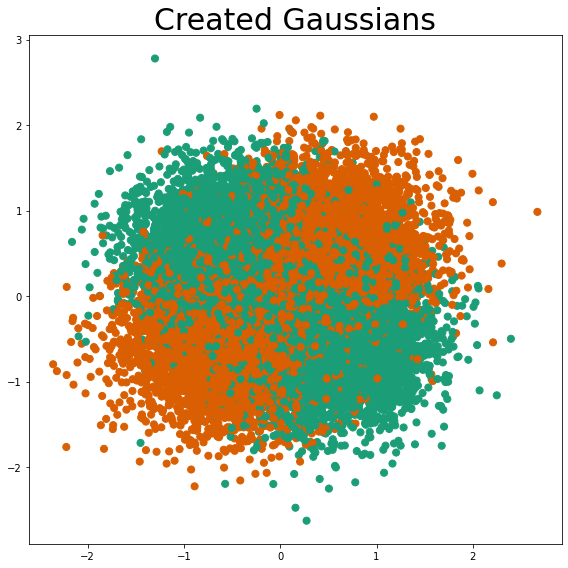

In [5]:
#Plotting Gaussians created by the function
def get_colors(colors, inds):
    c = [colors[i] for i in inds]
    return c


colors = sns.color_palette("Dark2", n_colors=2)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], c=get_colors(colors, y), s=50)
ax.set_title("Created Gaussians", fontsize=30)
plt.tight_layout()

### Estimation of Bayes' Error (Analytically)
#### NOTE: Here, the Gaussians are generated randomly, and hence, the value is not exactly what the actual Bayes' error of the problem is. Instead, the actual estimate can be computed numerically. However, for a complete understanding, the analytical steps are presented here. 

$C_{0}$ is class 0, $C_{1}$ is class 1, and $x$ is the current point <br>
Then, <br>
$$ p(x | C_{0}) = \mathcal{N}(\mu_{1}, \Sigma_{1}) + \mathcal{N}(\mu_{3}, \Sigma_{3})$$
$$ p(x | C_{1}) = \mathcal{N}(\mu_{2}, \Sigma_{2}) + \mathcal{N}(\mu_{4}, \Sigma_{4})$$

If $p(x | C_{0}) > p(x | C_{1})$, then assign x to class 0, <br>
Else, assign x to class 1 
<br>

Then, by Bayes' Theorem <br>
$$ p(C_{i} | x) = \frac{p(x | C_{i}) * p(C_{i})}{p(x)} $$


The whole decision space is then divided into regions $R_{i}$ such that if $x$ $\epsilon$ $ R_{i}$, it implies that $x$ $\epsilon$ $ C_{i}$

Bayes' Error = Integrate Probability of Incorrect Decision over all the Decision Regions <br> 
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp;&nbsp;
= $P$($x$ $\epsilon$ $ R_{0}$ | $C_{1}$) * $P(C_{1})$ + $P$($x$ $\epsilon$ $ R_{1}$ | $C_{0}$) * $P(C_{0})$ <br>
 &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp;&nbsp;
= $\int_{R_{0}}p(x | C_{1}) * p(C_{1}) dx + \int_{R_{1}}p(x | C_{0}) * p(C_{0}) dx $



### Estimated of Bayes' Error (Numerically)
A grid is constructed over the entire space from -1 to 1 along the X and Y-axes (in steps of 0.006)


In [6]:
p = np.arange(-1,1,step=0.006)
q = np.arange(-1,1,step=0.006)
xx, yy = np.meshgrid(p,q)
grid_samples = np.concatenate(
        (
            xx.reshape(-1,1),
            yy.reshape(-1,1)
        ),
        axis=1
) 
        

#### Calculation of Probability Density Function
The Gaussian Parity Problem, as defined for our experiments, has two input variables (x1 & x2) and is a multivariate normal distribution. The probability density function for all 4 defined Gaussians is calculated i.e. for 1st gaussian of class 0 (g01), 2nd gaussian of class 0 (g02), 1st gaussian of class 1 (g11) and 2nd gaussian of class 1 (g12) 

#### Assignment of Probability Density Function
At each stage, the current data point is assigned to the class with the highest probability at that point which corresponds to the maximum probability density function at that point. The error possible at this point is the maximum probability density function of the incorrect class. 
E.g. if point A is assigned to class 1 (because class 1 has the highest probability density function), the error inherently associated with this point is the maximum probability density function of the guassians belonging to class 0, as this would indicate an error. 

#### Calculation of Error in Probability Density Function
In the way these functions were defined, the gaussians are created independently. Thus, although the overall probability density functions of each class is given as a summation of the individual gaussians, due to the way the simulation is generated, all 4 gaussians are independent of each other. In each quadrant, all 4 gaussians are active, and classes are assigned according to the class of the selected gaussian. Effectively, the probability density function estimated at each point is then due to an inidividual gaussian, and not their summation. 

#### Calculation of Probability of Error at Each Point
Once the probability density function of the incorrect class is found (which corresponds to the probability density function of the error), the probability of an error occurring can be estimated: 

$$ \text{Error at a Point} = \frac{\text{Probability Density Function Value of Incorrect Class}}{\text{Summation of All Probability Density Function Values}} $$

#### Calculation of Bayes' Error 
This Error is calculated for all points in the meshgrid. The average error found is the value of the Bayes' Error for the current problem. 

In [7]:
errors = []
correct_class = 0
for i in range(grid_samples.shape[0]):
    coorx = grid_samples[i][0]
    coory = grid_samples[i][1]
    
    x = grid_samples[i]
    
    if((coorx >=0 and coory >=0) or (coorx <=0 and coory <=0)):
        true_class = 1 
    else:
        true_class = 0
    
    cov_scale = 0.5
    
    mu01 = np.array([-0.5,0.5])
    mu02 = np.array([0.5,-0.5])
    mu11 = np.array([0.5,0.5])
    mu12 = np.array([-0.5,-0.5])
    
    prob_g01 = scipy.stats.multivariate_normal(mu01, cov_scale).pdf(x)
    prob_g02 = scipy.stats.multivariate_normal(mu02, cov_scale).pdf(x)
    prob_g11 = scipy.stats.multivariate_normal(mu11, cov_scale).pdf(x)
    prob_g12 = scipy.stats.multivariate_normal(mu12, cov_scale).pdf(x)
    
    all_prob = [prob_g01, prob_g02, prob_g11, prob_g12]
    
    if(np.argmax(all_prob) == 3 or np.argmax(all_prob) == 2):
        predicted_class = 1
        errors.append(max(prob_g01, prob_g02) / (np.sum(all_prob)))
    else:
        predicted_class = 0
        errors.append(max(prob_g11, prob_g12) / (np.sum(all_prob)))
    
    if(predicted_class != true_class):
        print("Mismatch!")
        print("Predicted: ", predicted_class, "True: ", true_class)
        
error = np.sum(errors)/len(errors)
print("Overall Bayes' Probability of Error: ", error)



Overall Bayes' Probability of Error:  0.2671959038669435


### RESULT:  Bayes' Error for Gaussian Parity Problem is estimated as 0.267